In [14]:
import shap
shap.__version__

'0.32.1'

In [15]:
import tensorflow as tf
tf.__version__


'1.14.0'

In [16]:
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [17]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM,GRU
from keras.models import load_model
from keras import optimizers
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
def featurescale(X_train,X_test,y_train,y_test):
    x_scaler=MinMaxScaler() ##Min-max Scale 진행
    x_scaler.fit(X_train)
    X_train=x_scaler.transform(X_train) ## X_train을 기준으로 하고 Scaling 진행
    X_test=x_scaler.transform(X_test)
    y_scaler=MinMaxScaler()
    y_train=y_train.reshape(-1,1)
    y_test=y_test.reshape(-1,1)
    y_scaler.fit(y_train)
    y_train=y_scaler.transform(y_train)
    y_test=y_scaler.transform(y_test)
    return X_train,X_test, y_train,y_test,x_scaler, y_scaler

def PCAtransform(X_train,X_test,info):
    pca = PCA(n_components=info)
    pca.fit(X_train)
    pca_train = pca.transform(X_train)
    pca_test=pca.transform(X_test)
    n_components=(pca.n_features_in_)
    return pca, pca_train,pca_test, n_components

def make_dataset(data, label, to_predict,window_size=25,output_size=10):
    feature_list = []
    label_list = []
    for i in range(len(data)):
        end_ix = i + window_size
        out_end_ix = end_ix + output_size-1
        if out_end_ix+to_predict > len(data):
            break
        feature_list.append(np.array(data[i:i+window_size,:]))
        label_list.append(np.array(label[i+window_size-1+to_predict:out_end_ix+to_predict]))
    return np.array(feature_list), np.array(label_list)
def Lstmmodel(x_train,y_train,x_val,y_val):
  model = Sequential()
  lstm1=(LSTM(64, 
                input_shape=(x_train.shape[1], x_train.shape[2]), 
                activation='tanh', 
                return_sequences=False)
            )

  #model.add(Dropout(0.01))
  dense=(Dense(10))
  import os
  layers=[lstm1,dense]
  model=Sequential(layers)
  model.compile(loss='mean_squared_error', optimizer='adam')
  early_stop = EarlyStopping(monitor='val_loss', patience=15)
  model.summary()
  model_path = '/content/drive/MyDrive/Colab Notebooks/model'
  #filename = os.path.join(model_path, 'tmp_checkpoint.h5')
  #checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
  sgd = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9, nesterov=True)
  history = model.fit(x_train, y_train, 
                                      epochs=50, 
                                      batch_size=16,
                                      validation_data=(x_val,y_val),
                       callbacks=[ early_stop] 
                                      )
  #opt=load_model('/content/drive/MyDrive/Colab Notebooks/model/tmp_checkpoint.h5')
  return model
def GruModel(x_train,y_train,x_val,y_val):
    model = Sequential()
    Gru1=(GRU(64, 
                input_shape=(x_train.shape[1], x_train.shape[2]), 
                activation='tanh', 
                return_sequences=False)
            )
    #model.add(Dropout(0.01))

    dense=(Dense(10))
    import os
    layers=[Gru1,dense]
    model=Sequential(layers)
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=15)
    model.summary()
    #model_path = '/content/drive/MyDrive/Colab Notebooks/grumodel'
    #filename = os.path.join(model_path, 'tmp_checkpoint.h5')
   # checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    sgd = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9, nesterov=True)
    history = model.fit(x_train, y_train, 
                                      epochs=50, 
                                      batch_size=16,
                                      validation_data=(x_val,y_val),
                                      callbacks=[ early_stop])
    #opt=load_model('/content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5')
    return model
from sklearn.metrics import mean_squared_error, mean_absolute_error
def confirm_result(y_pred,test_label):
    RMSE=mean_squared_error(y_pred,test_label)
    MAE=mean_absolute_error(y_pred,test_label)
    #print("RMSE of PCA GRU : {} ".format(RMSE))
    #print("MAE of PCA GRU :{}".format(MAE))
    return RMSE

In [18]:

df=pd.read_csv("data_ver7.csv")
df.head()
#df=df.drop('연도',1) ##연도 column dropf
df=df.drop('시점',1)
df=df.drop('적상추 가격',1)
df=df.drop('깻잎 가격',1)
df=df.drop('양파 가격',1)
df=df.drop('감자 가격',1)
df=df.drop('고구마 가격',1)

#df=df.drop('콜금리',1)
#df=df.drop('KOSPI',1)


#print(df.columns)
#df=df.drop('LNG',1)
#df=df.drop('LNG',1)
features=(df.columns[:])
#print(df)
print(len(features))
from sklearn.preprocessing import MinMaxScaler
data=df.to_numpy()
from sklearn.model_selection import TimeSeriesSplit
x=data[:,0:]
y=data[:,0]

i=0
loss=[]
pcloss=[]
gruloss=[]
pcgruloss=[]

TRAIN_SIZE=4300
x_train=x[:TRAIN_SIZE,:]
x_test=x[TRAIN_SIZE:,:]
y_train=y[:TRAIN_SIZE]
y_test=y[TRAIN_SIZE:]
print(x.shape)
x_train,x_test,y_train,y_test,x_scaler,y_scaler=featurescale(x_train,x_test,y_train,y_test)

dayafter=0
VAL_NUM=400
nonpc_train,y_train=make_dataset(x_train,y_train,to_predict=dayafter)
nonpc_test,y_test=make_dataset(x_test,y_test,to_predict=dayafter)
nonpc_te=nonpc_test
nonpc_val=nonpc_test[:VAL_NUM,:,:]
nonpc_test=nonpc_test[VAL_NUM:,:,:]
y_train=y_train.reshape(nonpc_train.shape[0],10)
y_test=y_test.reshape(y_test.shape[0],y_test.shape[1])
y_val=y_test[:VAL_NUM,:].reshape(nonpc_val.shape[0],10)  ##validation 기준으로 validation loss가 15번동안 줄지않으면 멈춤. 300개로 설정
y_test=y_test[VAL_NUM:,:].reshape(nonpc_test.shape[0],10)


pca,pca_train,pca_test,n_components=PCAtransform(x_train[:,1:],x_test[:,1:],6)   ## train기준으로PCA ->0.9 이것만조절해주면서 확인? 


pc_train,_=make_dataset(pca_train,y_train,to_predict=dayafter) ##PCA를 LSTM input 형태에 맞게끔
pc_test,_=make_dataset(pca_test,y_test,to_predict=dayafter) ## LSTM input 형태에 맞게끔


pc_train=(np.concatenate([nonpc_train[:,:,0].reshape(nonpc_train.shape[0],nonpc_train.shape[1],1),pc_train ], -1))
pc_test=(np.concatenate([nonpc_te[:,:,0].reshape(nonpc_te.shape[0],nonpc_te.shape[1],1),pc_test ], -1))
pc_val=pc_test[:VAL_NUM,:,:]##validation 기준으로 validation loss가 15번동안 줄지않으면 멈춤. 300개로 설정
pc_test=pc_test[VAL_NUM:,:,:]

print(pc_train.shape)
pcGRU=GruModel(pc_train,y_train,pc_val,y_val) ##PCA +GRU
GRU=GruModel(nonpc_train,y_train,nonpc_val,y_val)
#model2=Lstmmodel(pc_train,y_train,pc_val,y_val)##PCA +LSTM
#pcy_pred=model2.predict(pc_test)
#pcGRUpred=pcGRU.predict(pc_test)
#pcRMSE=confirm_result(pcy_pred.flatten(),y_test.flatten())
#pcGRURMSE=confirm_result(pcGRUpred.flatten(),y_test.flatten())


34
(5479, 34)
(4267, 25, 7)


c:\Junho\envs\shap\lib\site-packages\ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 64)                13824     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 14,474
Trainable params: 14,474
Non-trainable params: 0
_________________________________________________________________
Train on 4267 samples, validate on 400 samples
Epoch 1/50
4267/4267 [==============================] - 4s 998us/step - loss: 0.0079 - val_loss: 0.0039
Epoch 2/50
4267/4267 [==============================] - 2s 550us/step - loss: 0.0035 - val_loss: 0.0029
Epoch 3/50
4267/4267 [==============================] - 2s 552us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 4/50
4267/4267 [==============================] - 2s 549us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/50
4267/4267 [==============================] - 2s 551us/step -

## PCA Simple SHAP

In [19]:
%matplotlib inline 
import matplotlib.pyplot as plt
import shap
from tensorflow.keras import backend
print(shap.__version__)
tf.compat.v1.disable_eager_execution()
explainer = shap.DeepExplainer(pcGRU, pc_train[:2000,:,:])
shap_values = explainer.shap_values(pc_test) # X_validate is 3d numpy.ndarray

shap.initjs()


0.32.1


In [20]:
sang=["청상추"]
pcacol = [f"PC{i:d}" for i in range(1,(pca_train.shape[1])+1)]
pcacol=sang+pcacol

### 1일뒤

(746, 25, 7)
(746, 25, 7)
(18650, 7)


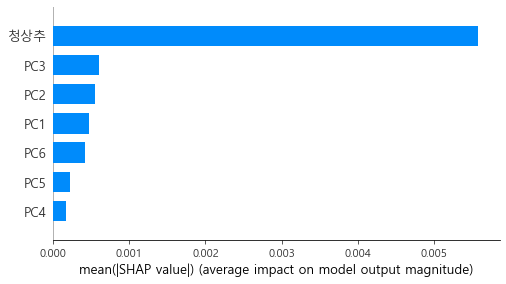

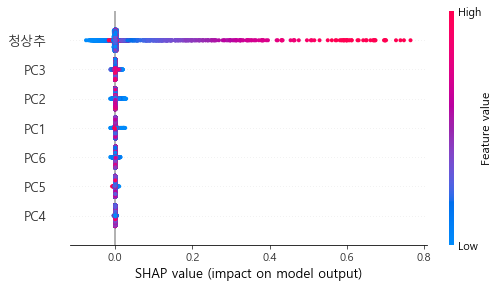

In [21]:
print(shap_values[0].shape)
print(pc_test.shape)
shap_values_2D=shap_values[0].reshape(-1,7)

matplotlib.rcParams['font.family'] ='Malgun Gothic' ##폰트깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] =False

x_val_2D=pc_test.reshape(-1,7)
print(x_val_2D.shape)
x_val_2D=pd.DataFrame(data=x_val_2D,columns=pcacol)

shap.summary_plot(shap_values_2D, x_val_2D,plot_type="bar")
shap.summary_plot(shap_values_2D, x_val_2D)

### 10일 뒤

(746, 25, 7)
(746, 25, 7)
(18650, 7)


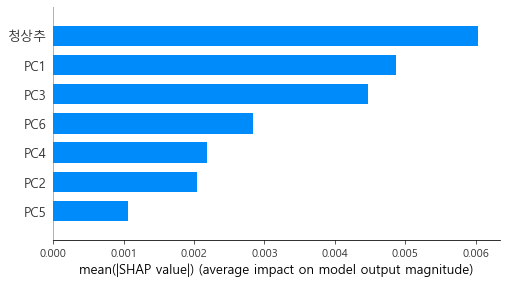

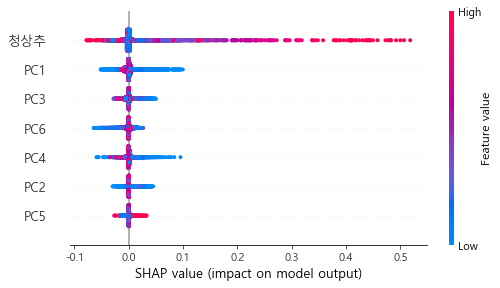

In [22]:
print(shap_values[9].shape)
print(pc_test.shape)
shap_values_2D=shap_values[9].reshape(-1,7)

matplotlib.rcParams['font.family'] ='Malgun Gothic' ##폰트깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] =False

x_val_2D=pc_test.reshape(-1,7)
print(x_val_2D.shape)
x_val_2D=pd.DataFrame(data=x_val_2D,columns=pcacol)

shap.summary_plot(shap_values_2D, x_val_2D,plot_type="bar")
shap.summary_plot(shap_values_2D, x_val_2D)

In [23]:
pcacol = [f"PC{i:d}" for i in range(1,(pca_train.shape[1])+1)]
loadings = pd.DataFrame(pca.components_.T, columns=pcacol, index=features[1:])
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
강원도 강수량(mm),-0.028071,0.002858,-0.001374,-0.069954,0.082620,-1.167266e-02
강원도 평균기온(℃),-0.358083,0.005426,0.022331,0.190575,0.012041,5.751174e-02
강원도 평균습도(%rh),-0.181898,-0.011801,-0.005585,-0.326552,-0.027550,-1.658631e-01
강원도 평균풍속(m/s),0.015991,0.024997,0.006454,0.027807,0.405895,6.358419e-02
광주 강수량(mm),-0.026617,-0.000549,-0.001769,-0.068510,0.052783,6.964700e-07
광주 평균기온(℃),-0.372366,0.000684,0.031776,0.184425,0.014728,-1.415836e-02
광주 평균습도(%rh),-0.167544,-0.050898,-0.031058,-0.443831,0.094213,-1.219451e-02
광주 평균풍속(m/s),-0.004421,0.046271,0.007018,0.009905,0.290129,2.045696e-02
대구 강수량(mm),-0.026929,0.000506,-0.005651,-0.068990,0.046173,-1.311928e-02
대구 평균기온(℃),-0.355159,0.015047,0.033819,0.210456,0.037736,2.808827e-02


## 전체 SHAP

In [24]:
%matplotlib inline 
import matplotlib.pyplot as plt
import shap
from tensorflow.keras import backend
print(shap.__version__)
tf.compat.v1.disable_eager_execution()
explainer = shap.DeepExplainer(GRU, nonpc_train[:2000,:,:])
shap_values = explainer.shap_values(nonpc_test) # X_validate is 3d numpy.ndarray

shap.initjs()

0.32.1


(746, 25, 34)
(746, 25, 7)
(18650, 34)


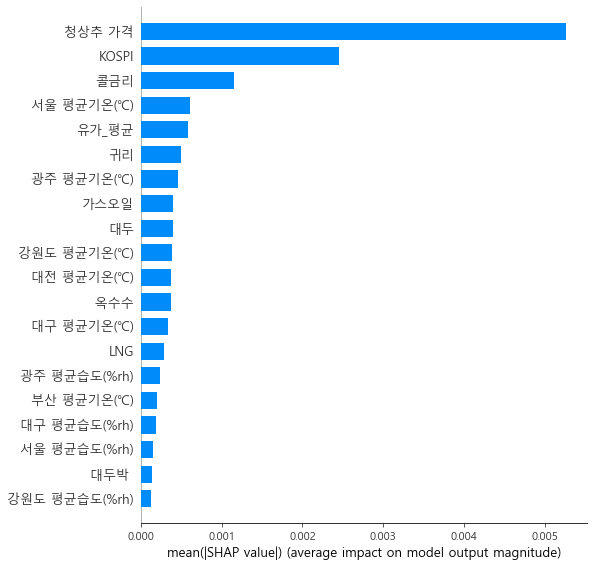

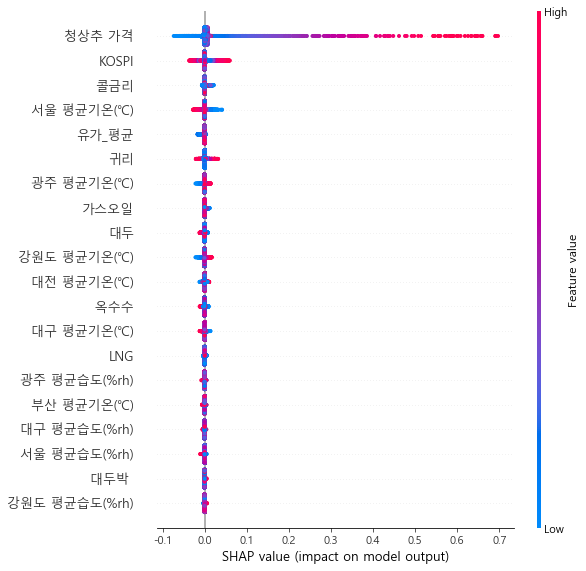

In [25]:
print(shap_values[0].shape)
print(pc_test.shape)
shap_values_2D=shap_values[0].reshape(-1,34)

matplotlib.rcParams['font.family'] ='Malgun Gothic' ##폰트깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] =False

x_val_2D=nonpc_test.reshape(-1,34)
print(x_val_2D.shape)
x_val_2D=pd.DataFrame(data=x_val_2D,columns=features)

shap.summary_plot(shap_values_2D, x_val_2D,plot_type="bar")
shap.summary_plot(shap_values_2D, x_val_2D)

(746, 25, 34)
(746, 25, 7)
(18650, 34)


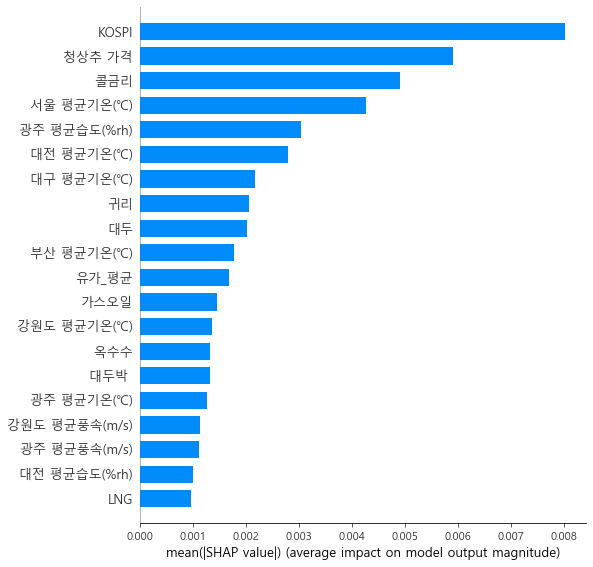

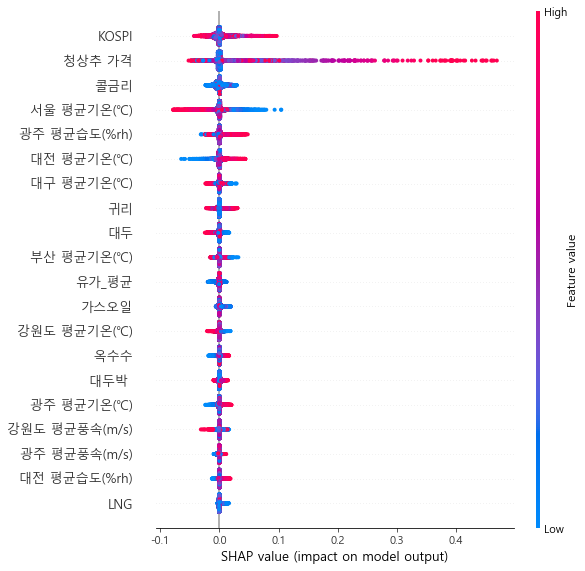

In [26]:
print(shap_values[9].shape)
print(pc_test.shape)
shap_values_2D=shap_values[9].reshape(-1,34)

matplotlib.rcParams['font.family'] ='Malgun Gothic' ##폰트깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] =False

x_val_2D=nonpc_test.reshape(-1,34)
print(x_val_2D.shape)
x_val_2D=pd.DataFrame(data=x_val_2D,columns=features)

shap.summary_plot(shap_values_2D, x_val_2D,plot_type="bar")
shap.summary_plot(shap_values_2D, x_val_2D)